Import libraries

In [1]:
import os 
import math
import copy
import torch
import random
import numpy as np
import collections
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from utils import load_pickle, load_json, pickle_data, write_json

Sample training data

In [2]:
datasets = ["canopus", "nist2023", "massspecgym"]
data_folder = "/data/rbg/users/klingmin/projects/MS_processing/data/"
splits_folder = "/data/rbg/users/klingmin/projects/MS_processing/data_splits/"

Helper Functions

In [3]:
def get_sample_level_oov(rec, formula_set):

    rec_peaks = set([p["comment"]["f_pred"] for p in rec["peaks"]])
    rec_peaks.discard("")

    if len(rec_peaks) == 0: return 1.0
    
    oov = rec_peaks.difference(formula_set)
    oov_rate = len(oov) / len(rec_peaks)
    return oov_rate

def get_ratio(spec):

    n_peaks = len(spec["peaks"])
    n_labelled = len([p for p in spec["peaks"] if p["comment"]["f_pred"] != ""])
    
    ratio = n_labelled / n_peaks

    return ratio

# For processing the MS 
def bin_MS(peaks, bin_resolution = 0.25, max_da = 2000):

    mz = [p["mz"] for p in peaks]
    intensities = [p["intensity"] for p in peaks]
    
    n_bins = int(math.ceil(max_da / bin_resolution))

    mz_binned = [0 for _ in range(n_bins)]
    for m, i in zip(mz, intensities):
        
        m = math.floor(m / bin_resolution)
        if m >= n_bins: continue 
        mz_binned[m] += i

    return mz_binned


def string_to_bits(string): 

    bits = np.array([int(c) for c in string])

    return bits

@torch.no_grad()
def batch_jaccard_index(FP_pred, FP):

    # Intersection = bitwise AND
    intersection = np.logical_and(FP, FP_pred).sum(axis=1)

    # Union = bitwise OR
    union = np.logical_or(FP, FP_pred).sum(axis=1)

    # Avoid division-by-zero by adding a small epsilon
    jaccard_scores = intersection / (union + 1e-9)

    return jaccard_scores

Load in the data

In [23]:
dataset_info = {} 

canopus = load_pickle(os.path.join(data_folder, "canopus", "canopus_w_mol_info_w_frag_CF_preds.pkl"))
canopus = {str(r["id_"]) : r for r in canopus}
print("Done loading canopus")

massspecgym = load_pickle(os.path.join(data_folder, "massspecgym", "massspecgym_w_mol_info_w_frag_CF_preds.pkl"))
massspecgym = {str(r["id_"]) : r for r in massspecgym}
print("Done loading MSG")

# nist2023 = load_pickle(os.path.join(data_folder, "nist2023", "nist2023_w_mol_info_w_frag_CF_preds.pkl"))
# nist2023 = {r["id_"] : r for r in nist2023}
# print("Done loading NIST2023")

dataset_info["canopus"] = canopus
dataset_info["massspecgym"] = massspecgym
# dataset_info["nist2023"] = nist2023

Done loading canopus
Done loading MSG


Get the rep sets

In [7]:
all_rep = {} 

for dataset in datasets:

    all_rep[dataset] = {} 
    if dataset not in dataset_info: continue

    for key, rec in dataset_info[dataset].items():
        
        inchikey = rec["inchikey_original"][:14]
        peaks = set([p["comment"]["f_pred"] for p in rec["peaks"]])
        peaks.discard("")

        rep = "_".join(sorted(peaks))

        if rep not in all_rep[dataset]: all_rep[dataset][rep] = [] 
        all_rep[dataset][rep].append((key, inchikey))

In [8]:
all_rep_sep = {} 

for dataset in datasets: 

    if dataset not in dataset_info: continue
    all_rep_sep[dataset] = {} 

    current_rep = all_rep[dataset]
    rep_sieved_single = {} 
    rep_sieved_same = {}
    rep_sieved_diff = {}

    for rep, lst in current_rep.items():

        if len(lst) == 1: 
            rep_sieved_single[rep] = lst
            continue
        inchikey_list = [r[1] for r in lst]
        if len(set(inchikey_list)) == 1: 
            rep_sieved_same[rep] = lst 
        else: 
            rep_sieved_diff[rep] = lst 
    
    all_rep_sep[dataset] = {"single": rep_sieved_single, 
                            "same": rep_sieved_same,
                            "diff": rep_sieved_diff}
    
    multiple = len(rep_sieved_diff) + len(rep_sieved_same)
    percent = len(rep_sieved_diff) / multiple * 100

Get the selected params

In [9]:
selected_params = {} 

for dataset in datasets: 

    if dataset not in dataset_info: continue
    
    current_split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_sieved.json")
    split = load_json(current_split_path)

    sample = dataset_info[dataset][split["train"][0].replace(".pkl", "")]
    precursor, instrument = sample["precursor_type"], sample["instrument_type"]

    selected_params[dataset] = {"precursor": precursor, "instrument": instrument}

selected_params

{'nist2023': {'precursor': '[M+H]+', 'instrument': 'HCD'}}

Consolidate dataset based on their inchikey

In [10]:
# canopus_standardized = {} 

# for k, v in canopus.items():

#     if v["precursor_type"] != selected_params["canopus"]["precursor"]: continue 
#     if v["instrument_type"] != selected_params["canopus"]["instrument"]: continue 
#     inchikey = v["inchikey_original"][:14]
#     if inchikey not in canopus_standardized: canopus_standardized[inchikey] = [] 
#     canopus_standardized[inchikey].append(v)

# massspecgym_standardized = {}

# for k, v in massspecgym.items():
#     if v["precursor_type"] != selected_params["massspecgym"]["precursor"]: continue 
#     if v["instrument_type"] != selected_params["massspecgym"]["instrument"]: continue 
#     inchikey = v["inchikey_original"][:14]
#     if inchikey not in massspecgym_standardized: massspecgym_standardized[inchikey] = [] 
#     massspecgym_standardized[inchikey].append(v)

nist2023_standardized = {} 

for k, v in nist2023.items():
    if v["precursor_type"] != selected_params["nist2023"]["precursor"]: continue 
    if v["instrument_type"] != selected_params["nist2023"]["instrument"]: continue 
    inchikey = v["inchikey_original"][:14]
    if inchikey not in nist2023_standardized: nist2023_standardized[inchikey] = [] 
    nist2023_standardized[inchikey].append(v)

Get the best sample based on the inchikey

In [12]:
selected = {} 
n_peaks = 30

canopus_selected_id = [] 
massspecgym_selected_id = [] 
nist2023_selected_id = [] 

# for inchikey, rec_list in canopus_standardized.items():

#     if len(rec_list) == 1: 
#         canopus_selected_id.append(rec_list[0]["id_"])
    
#     else:
#         scores = [get_ratio(dataset_info["canopus"][str(r["id_"])]) for r in rec_list]
#         chosen = rec_list[np.argmax(scores)]["id_"]
#         if len(dataset_info["canopus"][str(chosen)]["peaks"]) < n_peaks: continue
#         canopus_selected_id.append(str(chosen))

# selected["canopus"] = canopus_selected_id


# for inchikey, rec_list in massspecgym_standardized.items():

#     if len(rec_list) == 1: 
#         massspecgym_selected_id.append(rec_list[0]["id_"])
    
#     else:
#         scores = [get_ratio(dataset_info["massspecgym"][str(r["id_"])]) for r in rec_list]
#         chosen = rec_list[np.argmax(scores)]["id_"]
#         if len(dataset_info["massspecgym"][chosen]["peaks"]) < n_peaks: continue
#         massspecgym_selected_id.append(chosen)

# selected["massspecgym"] = massspecgym_selected_id

for inchikey, rec_list in nist2023_standardized.items():

    if len(rec_list) == 1: 
        nist2023_selected_id.append(rec_list[0]["id_"])
    
    else:
        scores = [get_ratio(dataset_info["nist2023"][str(r["id_"])]) for r in rec_list]
        chosen = rec_list[np.argmax(scores)]["id_"]
        if len(dataset_info["nist2023"][chosen]["peaks"]) < n_peaks: continue
        nist2023_selected_id.append(chosen)

selected["nist2023"] = nist2023_selected_id

print(len(canopus_selected_id), len(massspecgym_selected_id), len(nist2023_selected_id))

0 0 11441


Part 1: Get a training dataset with very "standardized experimental conditions"

In [27]:
for dataset in datasets: 

    if dataset not in dataset_info: continue 
    # selected_ids = selected[dataset]

    output_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_standard_expt.json")
    
    if not os.path.exists(output_path):

        original_split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla.json")
        split = load_json(original_split_path)
        
        train, val, test = split["train"], split["val"], split["test"]

        train_sieved = [t for t in train if t.replace(".pkl", "") in selected_ids]
        val_sieved = [t for t in val if t.replace(".pkl", "") in selected_ids]
        test_sieved = [t for t in test if t.replace(".pkl", "") in selected_ids]

        print(len(train), len(train_sieved))
        print(len(val), len(val_sieved))
        print(len(test), len(test_sieved))
        print()

        new_split = {"train": train_sieved, 
                    "val": val_sieved, 
                    "test": test_sieved}
        
        write_json(new_split, output_path)
    
    else: 

        new_split = load_json(output_path)

        train_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["train"]])
        val_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["val"]])
        test_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["test"]])

        print(dataset, "train", len(new_split["train"]), len(train_mol), "val", len(new_split["val"]), len(val_mol), "test", len(new_split["test"]), len(test_mol))

canopus train 128 128 val 25 25 test 28 28
massspecgym train 5460 5460 val 1320 1320 test 1431 1431


Part 2: Get a random comparison

In [29]:
for dataset in datasets: 

    if dataset not in dataset_info: continue

    output_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_subsampled.json")
    if not os.path.exists(output_path):

        print("Processing", output_path)

        original_split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla.json")
        current_split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_standard_expt.json")

        split = load_json(original_split_path)
        current_split = load_json(current_split_path)
        train, val, test = split["train"], current_split["val"], current_split["test"]
        n_train = len(current_split["train"])

        # Make sure that we only select the selected precursor and instrument 
        train_sieved = random.sample(train, k = n_train)

        new_split = {"train": train_sieved, 
                    "val": val, 
                    "test": test}
        
        write_json(new_split, output_path)
    
    else: 
        
        new_split = load_json(output_path)

        train_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["train"]])
        val_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["val"]])
        test_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["test"]])

        print(dataset, "train", len(new_split["train"]), len(train_mol), "val", len(new_split["val"]), len(val_mol), "test", len(new_split["test"]), len(test_mol))

canopus train 2043 1488 val 352 125 test 424 154
massspecgym train 5460 3418 val 1320 1320 test 1431 1431


Part 2: Continue to sieve out confusing cases

In [31]:
for dataset in datasets: 

    if dataset not in dataset_info: continue

    # ambiguous_examples = all_rep_sep[dataset]["diff"]
    # keys = [r[0] + ".pkl" for v in ambiguous_examples.values() for r in v]

    output_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_no_ambiguous.json")

    if not os.path.exists(output_path):

        current_split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_standard_expt.json")
        split = load_json(current_split_path)

        train, val, test = split["train"], split["val"], split["test"]
        train_sieved, val_sieved, test_sieved = [], [], []
        
        # Add all the confusing examples into the train
        for t in train:
            if t in keys: continue 
            train_sieved.append(t)

        # Ensure no leakage in val
        for v in val:
            if v in keys: continue 
            val_sieved.append(v)
        
        for t in test:
            if t in keys: continue 
            test_sieved.append(t)

        print(len(train), len(train_sieved))
        print(len(val), len(val_sieved))
        print(len(test), len(test_sieved))

        new_split = {"train": train, 
                    "val": val_sieved, 
                    "test": test_sieved}
        
        write_json(new_split, output_path)
    
    else: 
        
        new_split = load_json(output_path)

        train_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["train"]])
        val_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["val"]])
        test_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["test"]])

        print(dataset, "train", len(new_split["train"]), len(train_mol), "val", len(new_split["val"]), len(val_mol), "test", len(new_split["test"]), len(test_mol))

canopus train 128 128 val 25 25 test 28 28
massspecgym train 5460 5460 val 1306 1306 test 1419 1419


Part 3: Remove OOV cases

In [32]:
for dataset in datasets: 

    if dataset not in dataset_info: continue

    # ambiguous_examples = all_rep_sep[dataset]["diff"]
    # keys = [r[0] for v in ambiguous_examples.values() for r in v]

    output_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_no_ambiguous_low_oov.json")

    if not os.path.exists(output_path):

        current_split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_no_ambiguous.json")
        split = load_json(current_split_path)

        train, val, test = split["train"], split["val"], split["test"]
        train_CF = [dataset_info[dataset][r.replace(".pkl", "")]["peaks"] for r in train]
        train_CF = set([p["comment"]["f_pred"] for peak_list in train_CF for p in peak_list])

        val_sieved, test_sieved = [], []

        for v in val:

            oov_rate = get_sample_level_oov(dataset_info[dataset][v.replace(".pkl","")], train_CF)
            if oov_rate >= 0.1: continue

            val_sieved.append(v)

        for t in test:

            oov_rate = get_sample_level_oov(dataset_info[dataset][t.replace(".pkl","")], train_CF)
            if oov_rate >= 0.1: continue

            test_sieved.append(t)

        print(len(train))
        print(len(val), len(val_sieved))
        print(len(test), len(test_sieved))

        new_split = {"train": train, 
                    "val": val_sieved, 
                    "test": test_sieved}

        write_json(new_split, output_path)
    
    else: 
        
        new_split = load_json(output_path)

        train_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["train"]])
        val_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["val"]])
        test_mol = set([dataset_info[dataset][i.replace(".pkl", "")]["smiles"] for i in new_split["test"]])

        print(dataset, "train", len(new_split["train"]), len(train_mol), "val", len(new_split["val"]), len(val_mol), "test", len(new_split["test"]), len(test_mol))

canopus train 128 128 val 13 13 test 10 10
massspecgym train 5460 5460 val 1024 1024 test 1097 1097


`` Get the nearest neighbour ``

In [37]:
k = 1

for dataset in datasets:

    all_jaccard = [] 

    if dataset not in dataset_info: continue

    split_path = os.path.join(splits_folder, dataset, "splits", "scaffold_vanilla_no_ambiguous_low_oov.json")
    split = load_json(split_path)

    train_ids, test_ids = split["train"], split["test"]
    train_MS = [bin_MS(dataset_info[dataset][id_.replace(".pkl", "")]["peaks"]) for id_ in train_ids] 
    test_MS = [bin_MS(dataset_info[dataset][id_.replace(".pkl", "")]["peaks"]) for id_ in test_ids] 
    similarity = cosine_similarity(test_MS, train_MS)

    for i, test in enumerate(test_ids): 

        test_FP = string_to_bits(dataset_info[dataset][test.replace(".pkl", "")]["FPs"]["morgan4_4096"])
        test_FP = np.expand_dims(test_FP, axis = 0)
        top_k_train = np.argsort(similarity[i, :])[-k:][::-1]

        top_k_FP = np.array([string_to_bits(dataset_info[dataset][train_ids[j].replace(".pkl", "")]["FPs"]["morgan4_4096"]) for j in top_k_train])
        FP_pred = top_k_FP.sum(axis = 0)
        FP_pred = np.expand_dims(FP_pred, axis = 0)

        jaccard = batch_jaccard_index(FP_pred, test_FP)
        all_jaccard.append(jaccard)

    print(dataset, np.mean(all_jaccard))

canopus 0.1418647950014479
massspecgym 0.17962375449288387


In [40]:
k = 1

for dataset in datasets:

    all_jaccard = [] 

    if dataset not in dataset_info: continue

    for splitname in ["random", "inchikey_vanilla", "scaffold_vanilla", "LS"]:

        split_path = os.path.join(splits_folder, dataset, "splits", F"{splitname}.json")
        split = load_json(split_path)

        train_ids, test_ids = split["train"], split["test"]
        train_MS = [bin_MS(dataset_info[dataset][id_.replace(".pkl", "")]["peaks"]) for id_ in train_ids] 
        test_MS = [bin_MS(dataset_info[dataset][id_.replace(".pkl", "")]["peaks"]) for id_ in test_ids] 
        similarity = cosine_similarity(test_MS, train_MS)

        for i, test in enumerate(test_ids): 

            test_FP = string_to_bits(dataset_info[dataset][test.replace(".pkl", "")]["FPs"]["morgan4_4096"])
            test_FP = np.expand_dims(test_FP, axis = 0)
            top_k_train = np.argsort(similarity[i, :])[-k:][::-1]

            top_k_FP = np.array([string_to_bits(dataset_info[dataset][train_ids[j].replace(".pkl", "")]["FPs"]["morgan4_4096"]) for j in top_k_train])
            FP_pred = top_k_FP.sum(axis = 0)
            FP_pred = np.expand_dims(FP_pred, axis = 0)

            jaccard = batch_jaccard_index(FP_pred, test_FP)
            all_jaccard.append(jaccard)

        print(dataset, splitname, np.mean(all_jaccard))

canopus random 0.5143375818490198
canopus inchikey_vanilla 0.3997049704605526
canopus scaffold_vanilla 0.33596842768883595
canopus LS 0.2708476997374283
massspecgym random 0.7408818452251537
massspecgym inchikey_vanilla 0.48910329511489486


KeyboardInterrupt: 

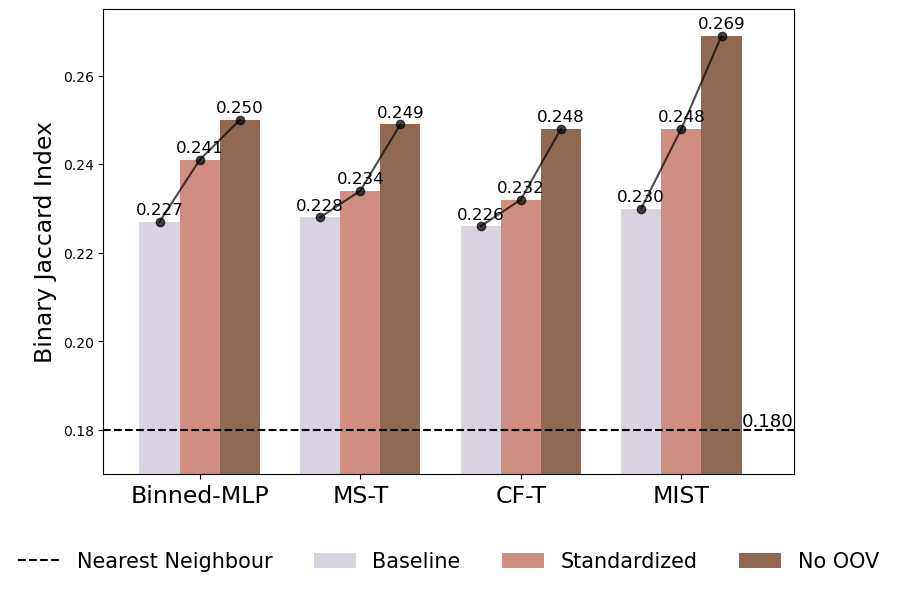

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: 4 methods × 3 conditions
data = {
    'Binned-MLP': [0.227, 0.241, 0.250],
    'MS-T': [0.228, 0.234, 0.249],
    'CF-T': [0.226, 0.232, 0.248],
    'MIST': [0.230, 0.248, 0.269],
}

conditions = ['Baseline', 'Standardized', 'No OOV']
methods = list(data.keys())
n_conditions = len(conditions)
n_methods = len(methods)

# Bar plot settings
x = np.arange(n_methods)  # One group per method
bar_width = 0.25
offsets = np.linspace(-1.0 * bar_width, 1.0 * bar_width, n_conditions)

all_colors = ["#D8D2E1", "#CF8E80", "#916953"]

plt.figure(figsize=(9, 6))

for i, (cond, offset) in enumerate(zip(conditions, offsets)):
    values = [data[m][i] for m in methods]
    bars = plt.bar(x + offset, values, width=bar_width, label=cond, color = all_colors[i])

    # Annotate each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.001,                 # slightly above bar
            f'{height:.3f}',                # format number
            ha='center', va='bottom', fontsize=12
        )

# Overlay lines per method showing trend
for i, m in enumerate(methods):
    y = data[m]
    x_line = x[i] + offsets
    plt.plot(x_line, y, color='black', linewidth=1.5, marker='o', alpha=0.7)

# Formatting
plt.xticks(x, methods, fontsize = 17)
plt.ylabel("Binary Jaccard Index", fontsize = 17)
plt.xlim(-0.6, 3.7)
plt.ylim(0.17, 0.275)

nn_perf = 0.180  # example NN performance
plt.axhline(nn_perf, color='black', linestyle='--', linewidth=1.5, label = "Nearest Neighbour")

plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,              # Arrange legend items in a row
    frameon=False,        # Optional: remove legend border
    fontsize = 15
)

# Optional: annotate the line
plt.text(
    x=plt.xlim()[1], y=nn_perf,
    s=f'{nn_perf:.3f}',
    ha='right', va='bottom', fontsize=13, color='black'
)
plt.tight_layout()
plt.savefig("./cache/baselines/performance_MSG.jpg")
plt.show()
